In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

assert torch.cuda.is_available()

# Problem 1
Download the CIFAR10 training and test datasets.
Transform them into tensors, normalize them as described above in the code, and create DataLoaders for each one. 
For the training set, use a batch size of 32, and for the test set, use a batch size of 1.

In [2]:
classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks')

# Normalize data and transform it into a tensor
transform = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download the CIFAR10 training data to ../data
train_data = datasets.CIFAR10('../data', train=True, download=True, 
                              transform=transform)

# create DataLoader
train_loader = DataLoader(train_data,batch_size=32,shuffle=True)



## Do the same for test set
# Download the CIFAR10 training data to ../data
test_data = datasets.CIFAR10('../data', train=False, download=True, 
                              transform=transform)

# create DataLoader
test_loader = DataLoader(test_data,batch_size=1,shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


# Problem 2

Create a convolution model class convoles an image of size $3\times 32 \times 32$ into a 1D tensor that represents the $10$ classes.
The model should have at least three convolution layers, each followed by an activation function, and include at least two linear layers and one maxpool layer.
Select channels and kernel sizes so that you get at least $50,000$ parameters.

Calculate and print the number of learnable parameters in your model.

Initialize your model and move it to the device.
Run the model on a single image to make sure there are no errors.


In [3]:
class ConvolutionModel(nn.Module):
    def __init__(self):
        super(ConvolutionModel, self).__init__()

        # Initialize the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, padding=2) #16x32x32
        self.relu1 = nn.ReLU() # 24x32x32
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, padding=2) 
            # 32x32x32
        self.relu2 = nn.ReLU()# 32x32x32
        self.maxpool = nn.MaxPool2d(kernel_size=2) # 32x16x16
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) 
            # 64x16x16
        self.relu3 = nn.ReLU() # 64x16x16
        self.maxpool = nn.MaxPool2d(kernel_size=2) # 64x8x8
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=10, kernel_size=3, padding=1) 
            # 10x8x8
        self.relu4 = nn.ReLU() # 10x8x8
        self.flatten = nn.Flatten() # 1x(10*8*8)
        self.linear = nn.Linear(in_features=10 * 8 * 8, out_features=10) # 1x10
    
    # Call the layers on an image
    def forward(self, x):
        output = self.relu1(self.conv1(x))
        output = self.relu2(self.conv2(output))
        output = self.maxpool(output)
        output = self.relu3(self.conv3(output))
        output = self.maxpool(output)
        output = self.relu4(self.conv4(output))
        output = self.flatten(output)
        return self.linear(output)


In [4]:
model = ConvolutionModel()

# Create the device, choosing GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
pytorch_total_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print("Total trainable params:", pytorch_total_params)

Total trainable params: 51732


In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
m = model(images[0].unsqueeze(0).to(device))
print(m)

tensor([[ 0.0073, -0.0086, -0.0248, -0.0166, -0.0373, -0.0091, -0.0045, -0.0367,
          0.0228, -0.0402]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Problem 3

Train the model by looping through the training data. Inside the loop, you should
1. Zero out the gradients.
2. Run the model on the inputs.
3. Calculate the loss on the model output and the actual label.
4. Backpropogate the error.
5. Optimize.

Run the loop for 10 epochs. At the end of each epoch, calculate the mean loss of the
training data for that epoch. Then calculate the accuracy of the model on the test data. Since
the model is no longer training, it needs to be set to evaluation mode using model.eval().
To resume training at the beginning of the next epoch, set the model to training mode using
model.train().

You should have around $50\%$ accuracy at the end of $10$ epochs.

Plot the epochs v. mean training loss each epoch and the epochs v. accuracy.


In [7]:
# store accuracy and training loss
acc = []
mean_train_loss_list = []


objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 10
for epoch in range(1,num_epochs+1):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), position=0)

    # used to calculate mean training loss 
    running_loss = 0.0
    total = 0

    # Loop through the data for training
    for batch, (x, y_truth) in loop:
        x, y_truth = x.to(device), y_truth.to(device)

        optimizer.zero_grad() # Zero out the the gradients
        outputs = model(x) # Run the model
        loss = objective(outputs, y_truth) # Calculate loss
        running_loss += loss.item()
        loss.backward() # Compute gradients
        optimizer.step() # Optimize and update the weights
        
        total += y_truth.size(0)

        # update progess bar
        loop.set_description('Epoch [{}/{}]'.format(
                                            epoch, num_epochs))
        loop.set_postfix(loss = loss.item())
        # loop.update()

    ## score model after each epoch
    
    model.eval()
    # training loss
    mean_train_loss_list.append(running_loss/total)

    # accuracy
    correct = 0
    total = 0
    for batch, (x, y_truth) in enumerate(test_loader):
        x, y_truth = x.to(device), y_truth.to(device)
        outputs = model(x) # Run the model

        # pick the argmax class as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += y_truth.size(0)
        correct += (predicted==y_truth).sum().item()
    
    acc.append(correct/total)
        



Epoch [10/10]: 100%|██████████| 1563/1563 [00:48<00:00, 31.97it/s, loss=1.16]


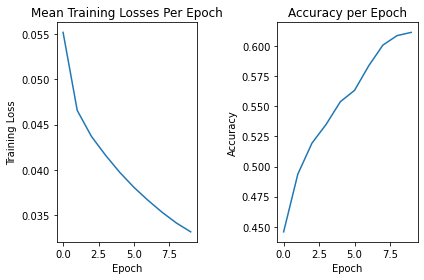

In [8]:
plt.subplot(121)

plt.plot(mean_train_loss_list)
plt.title("Mean Training Losses Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")

plt.subplot(122)
plt.plot(acc)
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

# Problem 4

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [9]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image adding clipping to maintain [-1,1] range
    return torch.clamp(perturbed_image, -1, 1)

In [12]:
# store images to display later
second = False
for (x, y) in test_loader:
    x1 = x.to(device)
    y1 = y.to(device)
    if second:
        break
    second = True

def adversarial(model, data_loader, eps):
    shown = False
    total = 0
    still_match = 0

    for (x, y_truth) in data_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        x.requires_grad = True
        outputs = model(x)
        total += 1 # keep count of total images
        _, predicted = torch.max(outputs.data, 1)
        if predicted != y_truth:
            continue

        loss = objective(outputs, y_truth) # Calculate loss
        optimizer.zero_grad() # Zero out the the gradients
        loss.backward()
        data_grad = x.grad.data

        # perturb the data
        perturbed_data = fgsm_attack(x, eps, data_grad)
        outputs = model(perturbed_data)

        _, predicted = torch.max(outputs.data, 1)
        if predicted == y_truth:
            still_match += 1

        # print first picture of test data
        if not shown:
            x1.requires_grad = True
            outputs = model(x1)
            total += 1 # keep count of total images
            _, predicted = torch.max(outputs.data, 1)
            if predicted != y1:
                continue

            loss = objective(outputs, y1) # Calculate loss
            optimizer.zero_grad() # Zero out the the gradients
            loss.backward()
            data_grad = x1.grad.data

            # perturb the data
            perturbed_data = fgsm_attack(x1, eps, data_grad)
            outputs = model(perturbed_data)

            _, predicted = torch.max(outputs.data, 1)
            shown = True
            img = perturbed_data.squeeze().detach().cpu().numpy()
            img = img/2 + 0.5 # unnormalize
            plt.imshow(np.transpose(img, (1, 2, 0)))
            plt.ylabel("Eps: {}".format(eps))
            plt.yticks([])
            plt.xticks([])
            plt.title("{} -> {}".format(classes[y1], classes[predicted]))
            plt.show()

        
        

    return still_match / total



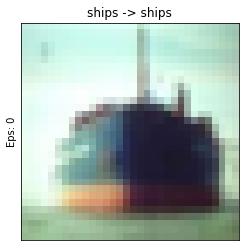

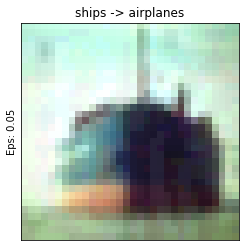

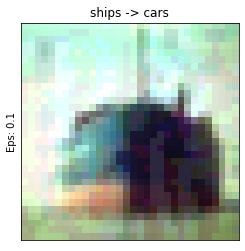

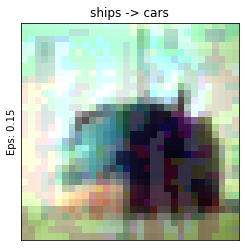

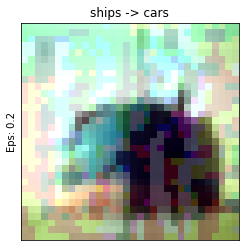

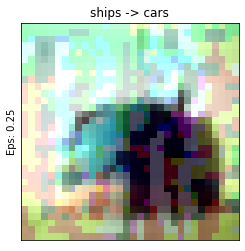

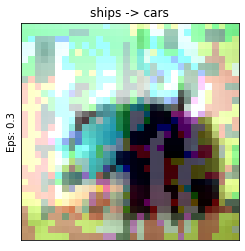

In [13]:
new_acc = []
model.eval()
eps_vals = [0, 0.05, .1, 0.15, 0.2, 0.25, 0.3]
for eps in eps_vals:

    new_acc.append(adversarial(model, test_loader, eps))

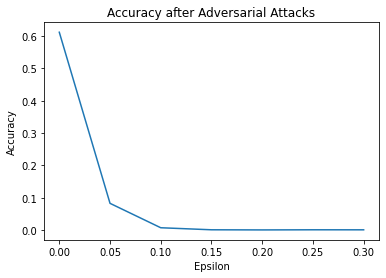

In [14]:

plt.plot(eps_vals, new_acc)
plt.title("Accuracy after Adversarial Attacks")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()